# Demonstration of oceanliner: OSSEs for SWOT in situ campaigns

This notebook enables a user to select an AdAC region and sampling trajectory (e.g., the path of an ocean glider or a ship-based underway CTD), and then does the following:
* download llc4320 data to the local machine
* compute steric height and potential vorticity 
* interpolate model fields in space/time over the trajectory
* return set of subsampled variables 
* store and plot outputs, including "true" versus "sampled" steric height 

### User inputs:
* **RegionName**: name of region (corresponding to filename) - options are WesternMed  ROAM_MIZ  NewCaledonia  NWPacific  BassStrait  RockallTrough  ACC_SMST MarmaraSea  LabradorSea  CapeBasin
* **start_date**, **ndays**: specify date range as start date & number of days.
* **SAMPLING_STRATEGY** : select whether you want to sample the model using a simulated glider track (`sim_glider`), a simulated underway ctd (`sim_uctd`), or a user-specified trajectory (`trajectory_file`), in which case **trajectory_file** must also be specified
* **PATTERN**: survey pattern -- can be `lawnmower` or `back-forth`
* **datadir** : directory where data files are stored



### Future developments to include:
* implement other sampling platforms (moorings, surface vessels, drifters)
* cloud version
* derivation of other variables, including simulated SWOT data
* piping output into optimal interpolation software
* implement other models



Code to download data from PO.DAAC adapted from [this demo](https://github.com/podaac/tutorials/blob/master/notebooks/Pre-SWOT_Numerical_Simulation_Demo.ipynb) by Jinbo Wang & Jack McNelis (JPL) 

In [1]:
## Imports

# Native packages
from math import radians, degrees, sin, cos, asin, acos, sqrt
import datetime
import sys


# Third-party packages for data manipulation
import numpy as np
import pandas as pd
import xarray as xr

# Third-party packages for data interpolation
from scipy import interpolate
from xgcm import Grid

# Third-party packages for data visualizations
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d

# osse tools package:
# del sys.modules['osse_tools'] 
from osse_tools import download_llc4320_data, compute_derived_fields, get_survey_track, survey_interp

In [2]:
# --------------------------------------------------------------------
# USER INPUTS:
# --------------------------------------------------------------------

# specify region from this list:
# WesternMed  ROAM_MIZ  NewCaledonia  NWPacific  BassStrait  RockallTrough  ACC_SMST
# MarmaraSea  LabradorSea  CapeBasin
RegionName = 'ACC_SMST' 

# specify date range as start date & number of days.
start_date = datetime.date(2012,1,1)
ndays = 31

# directory where data files are stored
# datadir = './data/' # default is ./data
datadir = '/data1/adac/mitgcm/netcdf/' + RegionName +'/'

## Set sampling strategy
# options: sim_glider, sim_uctd or trajectory_file
SAMPLING_STRATEGY = 'sim_glider'

# optional details for sampling (if not specified, reasonable defaults will be used)
sampling_details = {
    'PATTERN' : 'lawnmower', # back-forth or lawnmower 
    'zrange' : [-1, -1000],  # depth range of profiles (down is negative)
    'hspeed' : 0.25,  # platform horizontal speed in m/s
    'vspeed' : 0.1, # platform vertical (profile) speed in m/s 
    'trajectory_file' : None, # if SAMPLING_STRATEGY = 'trajectory_file', specify trajectory file
    'AT_END' : 'repeat' # behaviour at and of trajectory: 'reverse', 'repeat' or 'terminate'. (could also 'restart'?)
}

# --------------------------------------------------------------------

#### Download & load model data and derived fields

Based on [LLC4320](https://data.nas.nasa.gov/viz/vizdata/llc4320/index.html), the 1/48-degree global MITgcm simulation produced by the ECCO project. Ten regional cut-outs of the simulation are available on the [PO.DAAC](https://podaac.jpl.nasa.gov/datasetlist?ids=Processing+Levels&values=4+-+Gridded+Model+Output&search=Pre-SWOT+llc4320&view=list&provider=); the 4x4 degree regional domains are small enough to enable fairly easy downloads and processing. The data from the model were retrieved using download_llc4320.ipynb and saved locally.

In [3]:
# download files:
download_llc4320_data(RegionName, datadir, start_date, ndays)

# derive & save new files with steric height & vorticity
compute_derived_fields(RegionName, datadir, start_date, ndays)

LLC4320_pre-SWOT_ACC_SMST_20120101.nc
LLC4320_pre-SWOT_ACC_SMST_20120102.nc
LLC4320_pre-SWOT_ACC_SMST_20120103.nc
LLC4320_pre-SWOT_ACC_SMST_20120104.nc
LLC4320_pre-SWOT_ACC_SMST_20120105.nc
LLC4320_pre-SWOT_ACC_SMST_20120106.nc
LLC4320_pre-SWOT_ACC_SMST_20120107.nc
LLC4320_pre-SWOT_ACC_SMST_20120108.nc
LLC4320_pre-SWOT_ACC_SMST_20120109.nc
LLC4320_pre-SWOT_ACC_SMST_20120110.nc
LLC4320_pre-SWOT_ACC_SMST_20120111.nc
LLC4320_pre-SWOT_ACC_SMST_20120112.nc
LLC4320_pre-SWOT_ACC_SMST_20120113.nc
LLC4320_pre-SWOT_ACC_SMST_20120114.nc
LLC4320_pre-SWOT_ACC_SMST_20120115.nc
LLC4320_pre-SWOT_ACC_SMST_20120116.nc
LLC4320_pre-SWOT_ACC_SMST_20120117.nc
LLC4320_pre-SWOT_ACC_SMST_20120118.nc
LLC4320_pre-SWOT_ACC_SMST_20120119.nc
LLC4320_pre-SWOT_ACC_SMST_20120120.nc
LLC4320_pre-SWOT_ACC_SMST_20120121.nc
LLC4320_pre-SWOT_ACC_SMST_20120122.nc
LLC4320_pre-SWOT_ACC_SMST_20120123.nc
LLC4320_pre-SWOT_ACC_SMST_20120124.nc
LLC4320_pre-SWOT_ACC_SMST_20120125.nc
LLC4320_pre-SWOT_ACC_SMST_20120126.nc
LLC4320_pre-

In [4]:
# Load all model data files  
date_list = [start_date + datetime.timedelta(days=x) for x in range(ndays)]
target_files = [f'{datadir}LLC4320_pre-SWOT_{RegionName}_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files
ds = xr.open_mfdataset(target_files, parallel=True)

# load the corresponding derived fields
derivedir = datadir + 'derived/'
derived_files = [f'{derivedir}LLC4320_pre-SWOT_{RegionName}_derived-fields_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files
dsd = xr.open_mfdataset(derived_files)

# merge the derived and raw data
ds = ds.merge(dsd)

# Change time from datetime to integer
ds = ds.assign_coords(time=np.linspace(0,ds.time.size-1, num=ds.time.size)) # time is now in hours

# Convert lon, lat and z to index i, j and k with f_x, f_y and f_z
# XC, YC and Z are the same at all times, so select a single time
X = ds.XC.isel(time=0) 
Y = ds.YC.isel(time=0)

### Create & plot sampling track

In [5]:
# uncomment to troubleshoot
# del sys.modules['osse_tools'] 
# from osse_tools import download_llc4320_data, compute_derived_fields, get_survey_track, survey_interp

survey_track, survey_indices, sampling_parameters = get_survey_track(ds, SAMPLING_STRATEGY, sampling_details)

TypeError: get_survey_track() takes 2 positional arguments but 3 were given

### Visualizations

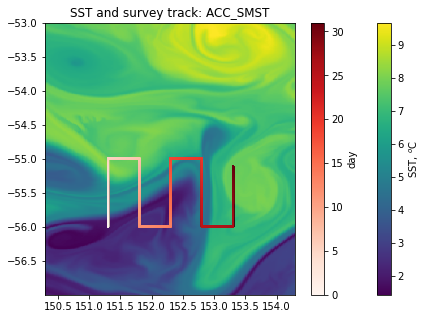

In [6]:
## Visualize track over a single model snapshot:
%matplotlib inline
plt.figure(figsize=(7,5))
ssto = plt.pcolormesh(X,Y,ds.Theta.isel(k=0, time=0).values, shading='auto')
tracko = plt.scatter(survey_track.lon, survey_track.lat, c=survey_track.time, cmap='Reds', s=0.75)
plt.title('SST and survey track: ' + RegionName)
plt.colorbar(ssto).set_label('SST, $^o$C')
plt.colorbar(tracko).set_label('day')
plt.show()

### Interpolate data with the specified sampling pattern (this is where the magic happens!)

In [7]:
# uncomment to troubleshoot
del sys.modules['osse_tools'] 
from osse_tools import download_llc4320_data, compute_derived_fields, get_survey_track, survey_interp

sdata, sh_true = survey_interp(ds, survey_track, survey_indices)

In [61]:

dum = -np.max([-sampling_details['zrange'][1], ds.Depth.isel(time=1).max(...).values])
dum

-4493.43115234375

### Visualize interpolated data in 3D

In [8]:
%matplotlib qt

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
fig.subplots_adjust(left=0.25, bottom=0.25)

ax.set_xlabel('longitude', fontsize=15, rotation=150)
ax.set_ylabel('latitude',fontsize=15)
ax.set_zlabel('depth', fontsize=15, rotation=60)

p = ax.scatter3D(sdata.lon.data, sdata.lat.data, sdata.dep.data, c=sdata.Theta.data, s=1)
fig.colorbar(p).set_label('Temperature ($^o$C)')
ax.set_title('Temperature interpolated to the survey track')

Text(0.5, 0.92, 'Temperature interpolated to the survey track')

### Visualize steric height

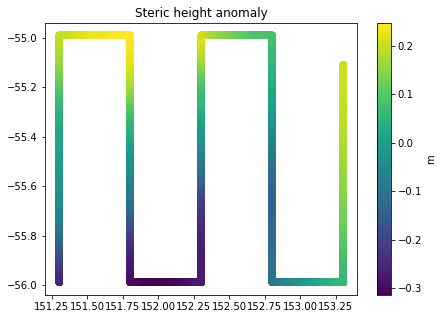

In [9]:
%matplotlib inline
sh_anom = sh_true.values - sh_true.values.mean()
plt.figure(figsize=(7,5))
sho = plt.scatter(survey_track.lon, survey_track.lat, c=sh_anom)
plt.title('Steric height anomaly')
plt.colorbar(sho).set_label('m')
plt.show()

### Comparison of true vs sampled steric height
Plot comparing the "true" steric height along the track and the subsampled steric height, which is computed by integrating the specific volume anomaly for each subsampled profile from its deepest sampling depth

Text(0, 0.5, 'steric height anom., m')

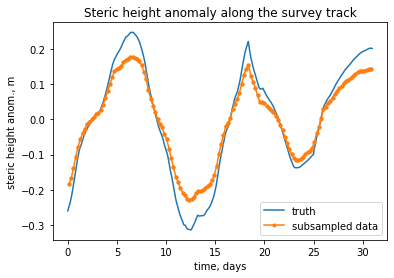

In [10]:
%matplotlib inline

# truth:
plt.plot(sh_true.time, sh_true.values - sh_true.values.mean())
# get index of the deepest sampling depths
i = ( sdata.dep.values == sdata.dep.values.min() )
plt.plot(sdata.time.values[i], sdata.steric_height.values[i] - sdata.steric_height.values[i].mean(),'.-')
plt.title('Steric height anomaly along the survey track')
plt.legend(['truth','subsampled data'])
plt.xlabel('time, days')
plt.ylabel('steric height anom., m')

Text(0, 0.5, 'steric height anom., m')

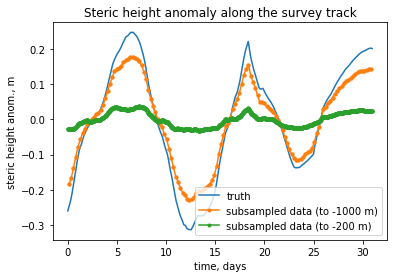

In [11]:
# compare a shallower sampling strategy:
sampling_details_shallow = dict(sampling_details)
sampling_details_shallow['zrange'] = [-1 ,-200]

# get track
survey_track_shallow, survey_indices_shallow, sampling_parameter_shallows = get_survey_track(ds, SAMPLING_STRATEGY, sampling_details_shallow)
# interpolate
sdata_shallow, sh_true_shallow = survey_interp(ds, survey_track_shallow, survey_indices_shallow)
# truth:
plt.plot(sh_true.time, sh_true.values - sh_true.values.mean())
# get index of the deepest sampling depths
i = ( sdata.dep.values == sdata.dep.values.min() )
plt.plot(sdata.time.values[i], sdata.steric_height.values[i] - sdata.steric_height.values[i].mean(),'.-')
j = ( sdata_shallow.dep.values == sdata_shallow.dep.values.min() )
plt.plot(sdata_shallow.time.values[j], sdata_shallow.steric_height.values[j] - sdata_shallow.steric_height.values[j].mean(),'.-')

plt.title('Steric height anomaly along the survey track')
plt.legend(['truth',r'subsampled data (to %d m)' % sampling_details['zrange'][1],
            r'subsampled data (to %d m)' % sampling_details_shallow['zrange'][1]])

plt.xlabel('time, days')
plt.ylabel('steric height anom., m')


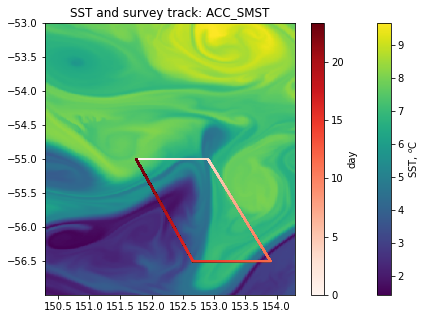

Text(0, 0.5, 'steric height anom., m')

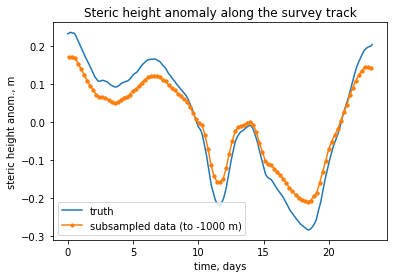

In [12]:
# sample with a user-input trajectory (created using make_trajectory_file.ipynb )
SAMPLING_STRATEGY_ex = 'trajectory_file'

# optional details for sampling (if not specified, reasonable defaults will be used)
sampling_details_ex = {
    'PATTERN' : None, # back-forth or lawnmower 
    'zrange' : None,  # depth range of profiles (down is negative)
    'hspeed' : None,  # platform horizontal speed in m/s
    'vspeed' : None, # platform vertical (profile) speed in m/s 
    'trajectory_file' : 'data/survey_trajectory_ACC_SMST_glider.nc', # if SAMPLING_STRATEGY = 'trajectory_file', specify trajectory file
    'AT_END' : 'terminate'
}

# get track
survey_track_ex, survey_indices_ex, sampling_parameter_shallows = get_survey_track(ds, SAMPLING_STRATEGY_ex, sampling_details_ex)
# interpolate
sdata_ex, sh_true_ex = survey_interp(ds, survey_track_ex, survey_indices_ex)


# plot:
plt.figure(figsize=(7,5))
ssto = plt.pcolormesh(X,Y,ds.Theta.isel(k=0, time=0).values, shading='auto')
tracko = plt.scatter(survey_track_ex.lon, survey_track_ex.lat, c=survey_track_ex.time, cmap='Reds', s=0.75)
plt.title('SST and survey track: ' + RegionName)
plt.colorbar(ssto).set_label('SST, $^o$C')
plt.colorbar(tracko).set_label('day')
plt.show()


# truth:
plt.plot(sh_true_ex.time, sh_true_ex.values - sh_true_ex.values.mean())
# get index of the deepest sampling depths
i = ( sdata_ex.dep.values == sdata_ex.dep.values.min() )
plt.plot(sdata_ex.time.values[i], sdata_ex.steric_height.values[i] - sdata_ex.steric_height.values[i].mean(),'.-')
plt.title('Steric height anomaly along the survey track')
plt.legend(['truth',r'subsampled data (to %d m)' % sampling_details['zrange'][1]])

plt.xlabel('time, days')
plt.ylabel('steric height anom., m')
